In [92]:
from __future__ import division, print_function
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score
from math import log, e
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import seaborn as sb
import matplotlib.pyplot as plt

In [9]:
weatherAUS = pd.read_csv('data set/weatherAUS.csv')
weatherAUS.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [10]:
weatherAUS  = weatherAUS.drop(['Location','Date','Evaporation','Sunshine', 'Cloud9am','Cloud3pm',
                           'WindGustDir','WindGustSpeed','WindDir9am','WindDir3pm','WindSpeed9am',
                           'WindSpeed3pm'], axis=1)

In [11]:
train_lables =  weatherAUS.RainTomorrow
train_data = weatherAUS.drop(['RainTomorrow'], axis=1)

In [68]:
def entropy2(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = e if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

In [109]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [130]:
entropy2(train_lables)

0.5321492783982418

In [129]:
print ('entropy = ', entropy2(train_lables[:1000]), 'Gini = ', gini(train_lables[:1000]))

entropy =  0.5368484029613974 Gini =  0.772


In [128]:
print ('entropy = ', entropy2(train_lables[140000:]), 'Gini = ', gini(train_lables[140000:]))

entropy =  0.354795567567032 Gini =  0.886000911992704


Not Rain :  31877
Rain:  110316


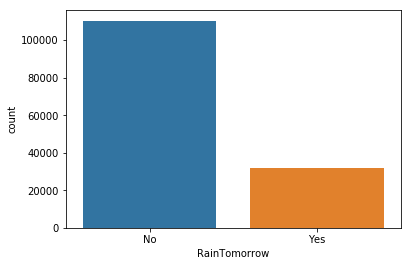

In [13]:
plot_sb = sb.countplot(train_lables, label='Total')
Rain, NotRain = train_lables.value_counts()
print('Not Rain : ',NotRain)
print('Rain: ',Rain)

In [14]:
train_data = train_data.replace({'No':0, 'Yes':1})
train_data = train_data.fillna(0)
train_lables = train_lables.replace({'No':0, 'Yes':1})
train_lables = train_lables.fillna(0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

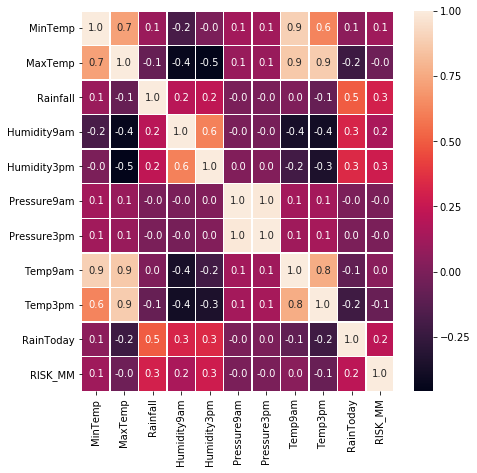

In [16]:
f, ax = plt.subplots(figsize=(7, 7))
sb.heatmap(train_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.xticks(rotation=90)

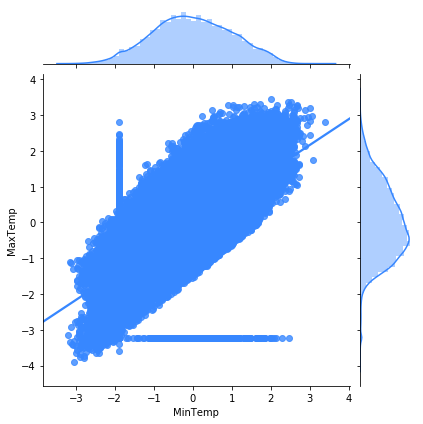

In [107]:
sb.jointplot(train_data_scaled.loc[:,'MinTemp'], 
              train_data_scaled.loc[:,'MaxTemp'], kind="regg", color="#3787ff")

In [18]:
train_data_matrix = train_data_scaled.as_matrix(['MinTemp', 'MaxTemp'])
train_data_matrix

array([[ 0.19690765, -0.03810915],
       [-0.73469006,  0.26766861],
       [ 0.11927451,  0.35106255],
       ...,
       [-1.32470194,  0.29546659],
       [-1.04522263,  0.51785042],
       [-0.67258355,  0.53174941]])

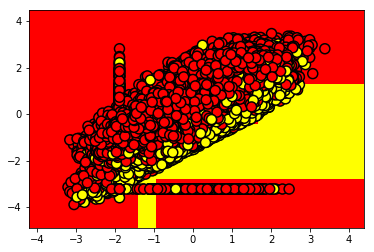

In [19]:
# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=17)

# обучаем дерево
clf_tree.fit(train_data_matrix, train_lables)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data_matrix)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data_matrix[:, 0], train_data_matrix[:, 1], c=train_lables, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5)

In [96]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[3,4,5,6,7,8,9,10,11,12,15,20]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(train_data_matrix, train_lables)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
from IPython.display import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())